In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
SEED = 42

### Data Simulation 

In [4]:
def simulate_data(n_samples, n_features):
    X = np.random.randn(n_samples, n_features)
    epsilon = np.random.randn(n_samples)
    Y = (1/np.sqrt(50)) * np.sum(X, axis=1) + epsilon
    return X, Y

In [5]:
n_train_sets = 500
n_train_samples = 100
n_test_samples = 600
n_features = 50
all_data = [simulate_data(n_train_samples, n_features) for _ in range(n_train_sets)]
X_test, y_test = simulate_data(n_test_samples, n_features)
all_m = [1,5,10,15,20,25,30,35,40,45,50]
n_splits = [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49]

# Figure 15.9

### Actual Computations  ( Parallelized and not Parallelized)

In [ ]:
def calculate_correlations(n_splits, all_data, X_test):
    rf = RandomForestRegressor(n_estimators=100, bootstrap=True) 

    def for_1_m(m):
        corr_m = []
        for X_test_batch in np.array_split(X_test, 10):  # Use batches of test samples
            X_test_corrs = []
            for X_train, y_train in all_data:
                rf.set_params(max_features=m)
                rf.fit(X_train, y_train)
                trees = rf.estimators_

                i = np.random.randint(0, len(trees))
                j = np.random.randint(0, len(trees))
                while i == j:
                    j = np.random.randint(0, len(trees))
                
                pred_i = trees[i].predict(X_test_batch)
                pred_j = trees[j].predict(X_test_batch)
                
                if len(pred_i) > 1 and len(pred_j) > 1:
                    pairwise_corrs = np.corrcoef(pred_i, pred_j)[0, 1]
                    X_test_corrs.append(pairwise_corrs)

            if X_test_corrs:
                corr_m.append(np.mean(X_test_corrs))
        print(f"done for {m}")
        return corr_m

    correlations = Parallel(n_jobs=-1)(delayed(for_1_m)(m) for m in n_splits)
    return correlations

n_splits = [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49]
correlations = calculate_correlations(n_splits, all_data, X_test)
plt.figure(figsize=(10, 6))
sns.boxplot(data=correlations,color='blue')
plt.xlabel('Number of Randomly Selected Splitting Variables (m)')
plt.ylabel('Correlation between Trees')
plt.title('Figure 15.9: Correlations between pairs of trees drawn by a random-forest regression algorithm, as a function of m')
plt.xticks(ticks=np.arange(len(n_splits)), labels=n_splits)
plt.savefig('15_9.png')

### Plotting Figure 15.9 !

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=correlations)
plt.xlabel('Number of Randomly Selected Splitting Variables (m)')
plt.ylabel('Correlation between Trees')
plt.title('Figure 15.9: Correlations between pairs of trees drawn by a random-forest regression algorithm, as a function of m')
plt.xticks(ticks=np.arange(len(n_splits)), labels=n_splits)
plt.show()

# Figure 15.10

### Actual Computations 

#### Computing the Total and within Variance !

In [ ]:
'''Non parallelized code'''
def compute_total_and_within(X_test,all_data,all_m):
    '''
    return the within variance and the total variance, assuming that the form is the following  within  variance = Ex_test Ez Var theta T(x,theta(z)) and the rf var= Ex_test Var Z  E theta T(x,theta(z))
    '''
    GRAPH_rf = []
    GRAPH_within = []
    for m in all_m:
        ARR_3_rf =  []
        ARR_3_within = []
        for x_test_i in X_test:
            ARR_2_rf = []
            ARR_2_within = []
            for X_train,y_train in all_data: # Z
                ARR_1_rf = []
                ARR_1_within = []
                rf = RandomForestRegressor(n_estimators=100, max_features=m, bootstrap=True)
                rf.fit(X_train,y_train)
                for tree in rf.estimators_:
                    temp = tree.predict([x_test_i])[0]
                    ARR_1_rf.append(temp)
                    ARR_1_within.append(temp)
                ARR_2_within.append(np.var(ARR_1_within))
                ARR_2_rf.append(np.mean(ARR_1_rf)) #rf.predict([x_test_i])[0] instead of np.mean(ARR_1_tot) it is in theory the same thing as the mean of the predictions of the trees is the prediction of the random forest
            ARR_3_rf.append(np.var(ARR_2_rf)) # Var Z 
            ARR_3_within.append(np.mean(ARR_2_within)) # E z
        GRAPH_rf.append(np.mean(ARR_3_rf)) # E x_test
        GRAPH_within.append(np.mean(ARR_3_within)) # E x_test
    total = np.array([GRAPH_within[i]+GRAPH_rf[i] for i in range(len(GRAPH_rf))])
    return GRAPH_within, total

np.save('total_and_within.npy',compute_total_and_within(X_test,all_data,all_m))






'''Parallelized code'''
def compute_variance_and_mean(X_train, y_train, x_test_i, m):
    rf = RandomForestRegressor(n_estimators=100, max_features=m, bootstrap=True, random_state=SEED)
    rf.fit(X_train, y_train)
    predictions = [tree.predict([x_test_i])[0] for tree in rf.estimators_]
    return np.var(predictions), np.mean(predictions)

def compute_total_and_within_single_m(X_test, all_data, m):
    rf_vars = []
    within_vars = []
    for x_test_i in X_test:
        results = Parallel(n_jobs=-1)(delayed(compute_variance_and_mean)(X_train, y_train, x_test_i, m) for X_train, y_train in all_data)
        within_var_list = [result[0] for result in results]
        mean_list = [result[1] for result in results]
        within_vars.append(np.mean(within_var_list))
        rf_vars.append(np.var(mean_list))
    return np.mean(within_vars), np.mean(rf_vars)

def compute_total_and_within(X_test, all_data, all_m):
    results = Parallel(n_jobs=-1)(delayed(compute_total_and_within_single_m)(X_test, all_data, m) for m in all_m)
    GRAPH_within = [result[0] for result in results]
    GRAPH_rf = [result[1] for result in results]
    return GRAPH_within, GRAPH_within + GRAPH_rf


within_var, total_var = compute_total_and_within(X_test, all_data, all_m)


np.save("within_variance.npy", within_var)
np.save("total_variance.npy", total_var) # for a technical reason I didn't pay attention that putting a + between two lists will concatenate them and not sum them element wise, and for that we need to do the following: (since in my parallel code function "COMPUTE_TOTAL_AND_WITHIN" I have done a concatenation between the var of the random forest(i.e. GRAPH_rf) and the within z variance (i.e. GRAPH_within)
within_var = np.load("within_variance.npy")
total_var = np.load("total_variance.npy")
tot_1 = total_var[0:11]
tot_2 = total_var[11:22]
total_var = [tot_1[i]+tot_2[i] for i in range(11)]





'''Computing the Variance for one single tree without bootstrapping'''
def compute_variance_and_mean_tree(X_train, y_train, x_test_i, m):
    #rf = RandomForestRegressor(n_estimators=100, max_features=m, bootstrap=True, random_state=SEED)
    rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, 
                                   min_samples_leaf=1, max_leaf_nodes=None, bootstrap=False, 
                                   random_state=SEED, max_features=m) # these parameters to make it explicit that we are growing fully grown trees !
    # Keep in mind that the max_features parameter is not used since we are not bootstrapping
    rf.fit(X_train, y_train)
    n_trees = 10
    random_indices = np.random.choice(len(rf.estimators_), size=n_trees, replace=False) # choosing random indices just like we talked about to sample from the population theta, Z
    predictions = [rf.estimators_[idx].predict([x_test_i])[0] for idx in random_indices]
    return np.var(predictions), np.mean(predictions)


def compute_total_and_within_single_m_tree(X_test, all_data, m):
    tot_vars = []
    within_vars = []
    for x_test_i in X_test:
        results = Parallel(n_jobs=-1)(delayed(compute_variance_and_mean_tree)(X_train, y_train, x_test_i, m) for X_train, y_train in all_data)
        within_var_list = [result[0] for result in results]
        mean_list = [result[1] for result in results]
        within_vars.append(np.mean(within_var_list))
        tot_vars.append(np.var(mean_list))
    return np.mean(within_vars), np.mean(tot_vars)

def compute_total_and_within_tree(X_test, all_data, all_m):
    results = Parallel(n_jobs=-1)(delayed(compute_total_and_within_single_m_tree)(X_test, all_data, m) for m in all_m)
    GRAPH_within = [result[0] for result in results]
    GRAPH_tot = [result[1] for result in results]
    tot = [GRAPH_within[i] + GRAPH_tot[i] for i in range(1)]
    return GRAPH_within, tot


all_m  = [1] # since bootstrapping is not used, the number of features is not relevant this is just a dummy variable to keep the code consistent

within_var, total_var = compute_total_and_within_tree(X_test, all_data, all_m)
np.save("single_full_tree_variance.npy", total_var)

#### PLotting the Left Figure !

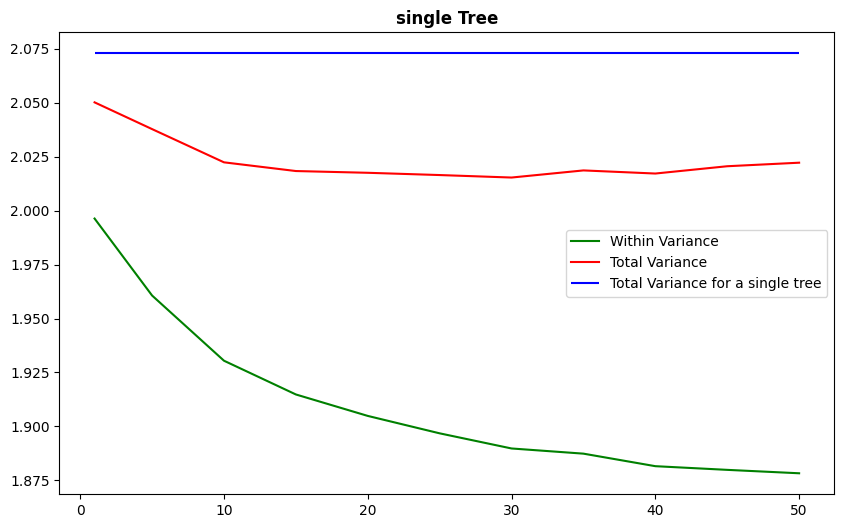

In [21]:
within_var_for_tree = np.load("single_tree_var.npy")[0]
within_var = np.load("within_variance.npy")
total_var = np.load("total_variance.npy") # reminder we need to address the technical issue of the concatenation of the two lists that we talked about
tot_1 = total_var[0:11]
tot_2 = total_var[11:22]
total_var = [tot_1[i]+tot_2[i] for i in range(11)] 



all_m = [1,5,10,15,20,25,30,35,40,45,50]
plt.figure(figsize=(10, 6))
plt.plot(all_m, within_var, label='Within Variance',color = 'green')
plt.plot(all_m, total_var, label='Total Variance',color = 'red')
plt.hlines(within_var_for_tree, all_m[0], all_m[-1], colors='b', linestyles='-', label='Total Variance for a single tree')
plt.legend(loc='center right')
plt.title('single Tree',fontweight='bold')
plt.savefig('15_10_left.png')

#### Computing the Bias 

In [ ]:
'''Parallelized code'''
def calculate_bias_squared(i, X_test_i, y_test, all_data, m, n_train_sets):
    AVG = 0
    for X_train, y_train in all_data:
        rf = RandomForestRegressor(n_estimators=100, max_features=m, bootstrap=True, random_state=42)
        rf.fit(X_train, y_train)
    
        temp = rf.predict([X_test_i])[0]
        AVG += temp
    AVG /= n_train_sets
    bias = AVG - (1/np.sqrt(50)) * np.sum(X_test_i) # at first I did a mistake by putting here y_test_i instead of f(x_test_i), but the correct formula is the one that is written here since we need the true function and not the y with noise
    bias_squared = bias ** 2
    return bias_squared
BIAS_SQAURED = []
for m in all_m:
    BIAS_for_test = Parallel(n_jobs=-1)(delayed(calculate_bias_squared)(i, X_test_i, y_test, all_data, m, n_train_sets) for i, X_test_i in enumerate(X_test))
    BIAS_SQAURED.append(np.mean(BIAS_for_test))

np.save("bias_squared.npy", BIAS_SQAURED)









'''Computing the Average Squared Bias for a single fully grown tree'''

def calculate_bias_squared_random_trees(i, X_test_i, y_test, all_data, m):
    rf = RandomForestRegressor(n_estimators=100, max_depth=None,  min_samples_split=2, min_samples_leaf=1,   max_leaf_nodes=None,bootstrap=True ,random_state=SEED,max_features=m)  # to ensure that the trees are fully grown, it wasn't clear that if we should use with bootstrapping or not, but I have chosen to use it since it wasn't mentioned explicitly that we shouldn't as they did with the variance question
    f_i = (1/np.sqrt(50)) * np.sum(X_test_i)
    AVG = [] # average over Z
    for X_train, y_train in all_data:
        
        rf.fit(X_train, y_train)

        # Randomly select the number of trees to average from this forest for this particular z and x_test_i
        n_trees_to_average = np.random.randint(1, len(rf.estimators_))
        
        # Randomly select the indices of the n trees chosen to average
        random_indices = np.random.choice(len(rf.estimators_), size=n_trees_to_average, replace=False)

        #Compute the average over E theta|z for not all theta !!!! as explained in the report 
        AVG_1 = [rf.estimators_[idx].predict([X_test_i])[0] for idx in random_indices] # average over theta|z
        AVG.append(np.mean(AVG_1))
    # average bias squared over all Z for this x_test_i
    AVG = np.mean(AVG)
    bias = AVG - f_i
    bias_squared = bias ** 2
    return bias_squared
all_m = [1,5,10,15,20,25,30,35,40,45,50]
BIAS_SQUARED = []

for m in all_m:
    BIAS_for_test = Parallel(n_jobs=-1)(delayed(calculate_bias_squared_random_trees)(i, X_test_i, y_test, all_data, m) for i, X_test_i in enumerate(X_test))
    mean_bias_squared = np.mean(BIAS_for_test)
    BIAS_SQUARED.append(mean_bias_squared)
    print(f"m = {m} = {mean_bias_squared}")

np.save("SQUARED_BIAS_FOR_FULL_GROWN_TREES.npy.npy", BIAS_SQUARED.mean())#we are interested in the average bias squared over all m since that is what they told us

##### PLotting the right Figure 

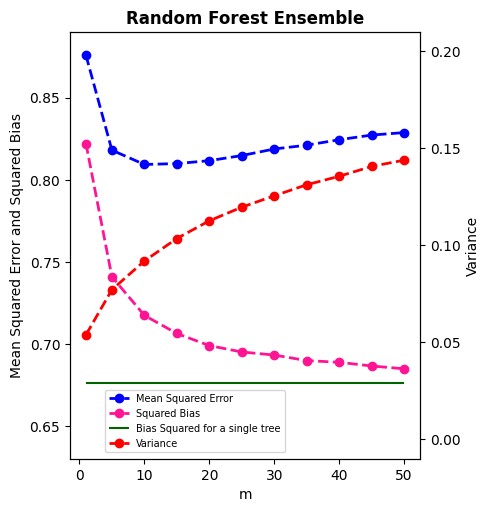

In [103]:
all_m = [1,5,10,15,20,25,30,35,40,45,50]
Bias_one_tree  =np.load("SQUARED_BIAS_FOR_FULL_GROWN_TREES.npy")

total_var = np.load("total_variance.npy")
tot_1 = total_var[0:11]
tot_2 = total_var[11:22]
total_var = [tot_1[i]+tot_2[i] for i in range(11)]

within_var = np.load("within_variance.npy")

variance_forest  =  [total_var[i]-within_var[i] for i in range(11)]
BIAS_SQAURED = np.load("bias_squared.npy")
MSE = [BIAS_SQAURED[i] + variance_forest[i] for i in range(11)]

fig, ax1 = plt.subplots(figsize=(5, 5))

ax1.plot(all_m, MSE, color='blue', label='Mean Squared Error', marker='o',linestyle='--',linewidth=2)
ax1.plot(all_m, BIAS_SQAURED, color='deeppink', label='Squared Bias', marker='o',linestyle='--',linewidth=2,alpha=1)
ax1.hlines(y=Bias_one_tree, xmin=1, xmax=50, color='darkgreen', linestyle='-', label='Bias Squared for a single tree')
ax1.set_xlabel('m')
ax1.set_ylabel('Mean Squared Error and Squared Bias')
ax1.set_yticks([0.65,0.7,0.75,0.8,0.85])
ax1.set_ylim(0.63, 0.89)


ax2 = ax1.twinx()
ax2.plot(all_m, variance_forest, color='red', label='Variance', marker='o',linestyle='--',linewidth=2,alpha=1)
ax2.set_ylabel('Variance')
ax2.set_yticks([0,0.05,0.1,0.15,0.2])
ax2.set_ylim(-0.01, 0.21)


fig.legend(loc = 'lower center',bbox_to_anchor=(0.4, 0.12),fontsize=7)
plt.tight_layout()
plt.title('Random Forest Ensemble',fontweight='bold')
plt.show()